## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [81]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv')[columns].fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [82]:
df.head()

,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
0,Brooklyn,Private room,40.64749,-73.97237,1,9,0.21,6,365,149
1,Manhattan,Entire home/apt,40.75362,-73.98377,1,45,0.38,2,355,225
2,Manhattan,Private room,40.80902,-73.94190,3,0,0.00,1,365,150
3,Brooklyn,Entire home/apt,40.68514,-73.95976,1,270,4.64,1,194,89
4,Manhattan,Entire home/apt,40.79851,-73.94399,10,9,0.10,1,0,80


In [83]:
df['price'] = np.log1p(df['price'])
df.head()

,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
0,Brooklyn,Private room,40.64749,-73.97237,1,9,0.21,6,365,5.010635
1,Manhattan,Entire home/apt,40.75362,-73.98377,1,45,0.38,2,355,5.420535
2,Manhattan,Private room,40.80902,-73.94190,3,0,0.00,1,365,5.017280
3,Brooklyn,Entire home/apt,40.68514,-73.95976,1,270,4.64,1,194,4.499810
4,Manhattan,Entire home/apt,40.79851,-73.94399,10,9,0.10,1,0,4.394449


In [84]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [85]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [86]:
del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text


In [88]:
train_dicts = df_train.to_dict(orient='records')
val_dicts =  df_val.to_dict(orient='records')

In [89]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [90]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=1)

dt.fit(X_train, y_train)    

DecisionTreeRegressor(max_depth=1)

In [91]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [92]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=1)


In [93]:
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, random_state=1)

In [94]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [95]:
rmse(rf.predict(X_val), y_val)

0.4598535778342608

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [96]:
rmse_dict = {}
for i in range(10, 201, 10):
   rf = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=-1) 
   rf.fit(X_train, y_train)
   x_predict = rf.predict(X_val)
   rmse_i = rmse(x_predict, y_val)
   rmse_dict[i] = rmse_i


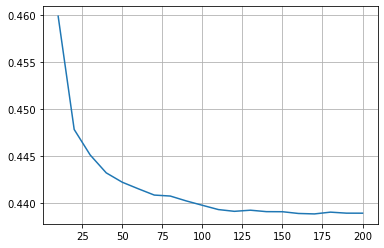

In [97]:
pd.Series(rmse_dict).plot()
plt.grid()
plt.show()

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [98]:
rmse_md_dict = {}
for d in [10, 15, 20, 25]:
    rmse_dict = {}
    for i in range(10, 201, 10):
       rf = RandomForestRegressor(n_estimators=i, max_depth=d, random_state=1, n_jobs=-1)
       rf.fit(X_train, y_train)
       x_predict = rf.predict(X_val)
       rmse_i = rmse(x_predict, y_val)
       rmse_dict[i] = rmse_i
    rmse_md_dict[d] = rmse_dict

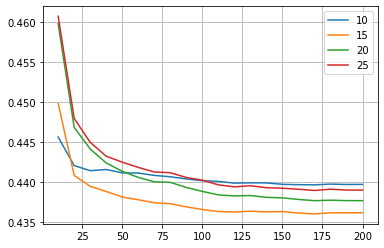

In [99]:
for d in [10, 15, 20, 25]:
    x = rmse_md_dict[d].keys()
    y = list(rmse_md_dict[d].values())
    plt.plot(x, y, label=d)
plt.grid()
plt.legend()
plt.show()    

In [100]:
for d in [10, 15, 20, 25]:
   minval = min(rmse_md_dict[d].values())
   print ("Min value for d {} is {}".format(d, minval))


Min value for d 10 is 0.43962454408704643
Min value for d 15 is 0.43598867668739827
Min value for d 20 is 0.4376444598387768
Min value for d 25 is 0.4389174495910712


What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [101]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)

In [102]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [103]:
features = dv.get_feature_names()

In [104]:
feat_list = list(zip(features, rf.feature_importances_))

In [105]:
feat_list

[('availability_365', 0.07656575602038891),
 ('calculated_host_listings_count', 0.030263881888999422),
 ('latitude', 0.15175550002877586),
 ('longitude', 0.15347560060953339),
 ('minimum_nights', 0.05316959753835208),
 ('neighbourhood_group=Bronx', 0.0004472734749035815),
 ('neighbourhood_group=Brooklyn', 0.0011145011423147665),
 ('neighbourhood_group=Manhattan', 0.034043659332215426),
 ('neighbourhood_group=Queens', 0.001034143501453153),
 ('neighbourhood_group=Staten Island', 8.371271708698621e-05),
 ('number_of_reviews', 0.042518523151637094),
 ('reviews_per_month', 0.05459457652195896),
 ('room_type=Entire home/apt', 0.3918980233885284),
 ('room_type=Private room', 0.004877070765213998),
 ('room_type=Shared room', 0.004158179918638004)]

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

In [124]:
sorted(feat_list, key=lambda tup: tup[1], reverse=True)

[('room_type=Entire home/apt', 0.3918980233885284),
 ('longitude', 0.15347560060953339),
 ('latitude', 0.15175550002877586),
 ('availability_365', 0.07656575602038891),
 ('reviews_per_month', 0.05459457652195896),
 ('minimum_nights', 0.05316959753835208),
 ('number_of_reviews', 0.042518523151637094),
 ('neighbourhood_group=Manhattan', 0.034043659332215426),
 ('calculated_host_listings_count', 0.030263881888999422),
 ('room_type=Private room', 0.004877070765213998),
 ('room_type=Shared room', 0.004158179918638004),
 ('neighbourhood_group=Brooklyn', 0.0011145011423147665),
 ('neighbourhood_group=Queens', 0.001034143501453153),
 ('neighbourhood_group=Bronx', 0.0004472734749035815),
 ('neighbourhood_group=Staten Island', 8.371271708698621e-05)]

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [107]:
import xgboost as xgb

In [108]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [109]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [110]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [111]:
%%capture output

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)
s = output.stdout

In [112]:
print(s)

[0]	train-rmse:3.02752	val-rmse:3.02415
[10]	train-rmse:0.43912	val-rmse:0.44981
[20]	train-rmse:0.41716	val-rmse:0.43691
[30]	train-rmse:0.40712	val-rmse:0.43543
[40]	train-rmse:0.40103	val-rmse:0.43466
[50]	train-rmse:0.39446	val-rmse:0.43384
[60]	train-rmse:0.38743	val-rmse:0.43404
[70]	train-rmse:0.38117	val-rmse:0.43467
[80]	train-rmse:0.37668	val-rmse:0.43526
[90]	train-rmse:0.36998	val-rmse:0.43539
[99]	train-rmse:0.36478	val-rmse:0.43621



In [113]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

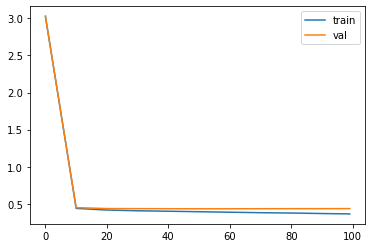

In [114]:
df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()


In [115]:
 min(zip(df_score.val_auc, df_score.num_iter))

(0.43384, 50)

Now change `eta` first to `0.1` and then to `0.01`

In [116]:
%%capture output1
xgb_params['eta'] = 0.1
model = xgb.train(xgb_params, dtrain, num_boost_round=100,  evals=watchlist, verbose_eval=10)

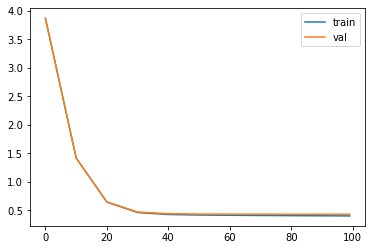

In [117]:
df_score = parse_xgb_output(output1)

plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()


In [118]:
 min(zip(df_score.val_auc, df_score.num_iter))

(0.4325, 99)

In [119]:
%%capture output2
xgb_params['eta'] = 0.01
model = xgb.train(xgb_params, dtrain, num_boost_round=100,  evals=watchlist, verbose_eval=10)

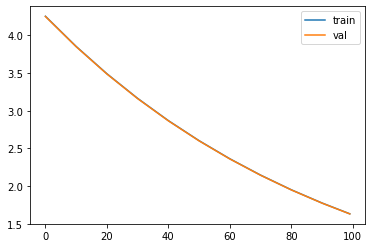

In [120]:
df_score = parse_xgb_output(output2)

plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [121]:
 min(zip(df_score.val_auc, df_score.num_iter))

(1.63045, 99)

What's the best eta?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

